In [112]:
# Import delle librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # Modulo regex per estrarre numeri/pattern

# Stile
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)

In [113]:
df = pd.read_csv(
    "Cars_Datasets_2025.csv",
    sep=",",
    engine="python",
    quotechar='"',
    encoding="cp1252",   # Windows encoding
    on_bad_lines="warn"
)

PULIZIA DEL DATASET: le colonne contengono unità di misura e simboli -> vanno ripulite

In [114]:

def extract_numbers_from_string(s): # Estrae tutti i numeri (interi o con decimali) da una stringa

    if pd.isna(s): # Se la stringa è NaN o non-text, ritorna []
        return []
    
    # Forzo a stringa (in caso di numeri già presenti)
    s = str(s)
    
    # Trova tutte le occorrenze numeriche (es: "70-85" -> ["70","85"], "300 (est.)" -> ["300"])
    nums = re.findall(r'\d+\.?\d*', s)
    return nums

In [115]:
def parse_numeric_value(s, prefer_mean_for_range=True):
    
    """
        Normalizza un campo testuale che contiene:
        - un singolo numero -> restituisce quel numero (float)
        - un range 'low-high' -> restituisce la media (float) se prefer_mean_for_range True, altrimenti restituisce il low
        - valori con testo tra parentesi '300 (est.)' -> estrae 300
        - valori con '+', ',' simboli -> pulisce e interpreta il numero
        
        Se non trova numeri ritorna nan.
    """
    
    nums = extract_numbers_from_string(s)
    
    if not nums: # Nessun numero -> nan
        return np.nan
    
    if len(nums) == 1: # Singolo numero -> ritorna float
        return float(nums[0])
    
    else: # più numeri -> interpreto come range -> media
        arr = [float(x) for x in nums]
        if prefer_mean_for_range:
            return float(np.mean(arr))
        else:
            return float(arr[0])  # o arr[0] come low

In [116]:
def clean_price_generic(price_str):
    """
        Versione per i prezzi:
        - rimuove simboli $ e spazi e virgole
        - se c'è un range, usa la media
        - se non trova numeri ritorna NaN
    """
    
    if pd.isna(price_str):
        return np.nan
    
    s = str(price_str).replace("$", "").replace(",", "").strip()
    
    return parse_numeric_value(s, prefer_mean_for_range=True) # usa parse_numeric_value per estrarre numero o media se range

In [117]:
# ---- HorsePower: gestisco range come media, rimuovo 'hp' se presente ----
df["HorsePower_clean"] = df["HorsePower"].apply(parse_numeric_value)

# ---- Total Speed: gestisco '300 (est.)', range, ecc. ----
df["TotalSpeed_clean"] = df["Total Speed"].apply(parse_numeric_value)

# ---- Performance (0-100) in secondi: ex. '2.5 sec' o '10.5 sec' ----
df["Performance_0_100_clean"] = df["Performance(0 - 100 )KM/H"].apply(parse_numeric_value)

# ---- CC/Battery Capacity: rimuovo 'cc', virgole, ecc. ----
df["CC_clean"] = df["CC/Battery Capacity"].apply(parse_numeric_value)

# ---- Seats: può essere già numerico ma uso pd.to_numeric con coercion -> converte valori non interpretabili in nan invece di lanciare ValueError ----
df["Seats_clean"] = pd.to_numeric(df["Seats"], errors="coerce")

# ---- Torque: potrebbe contenere '100 - 140 Nm' oppure '900 Nm' ----
df["Torque_clean"] = df["Torque"].apply(parse_numeric_value)

# ---- Cars Prices: usa funzione che pulisce $ , e gestisce range ----
df["CarsPrices_clean"] = df["Cars Prices"].apply(clean_price_generic)

CONTO VALORI NULLI


--- CONTEGGIO VALORI NULLI PRE-PULIZIA ---
Company Names                 0
Cars Names                    0
Engines                       0
CC/Battery Capacity           3
HorsePower                    0
Total Speed                   0
Performance(0 - 100 )KM/H     6
Cars Prices                   0
Fuel Types                    0
Seats                         0
Torque                        1
HorsePower_clean              0
TotalSpeed_clean              0
Performance_0_100_clean       6
CC_clean                      5
Seats_clean                  12
Torque_clean                  1
CarsPrices_clean              1
dtype: int64


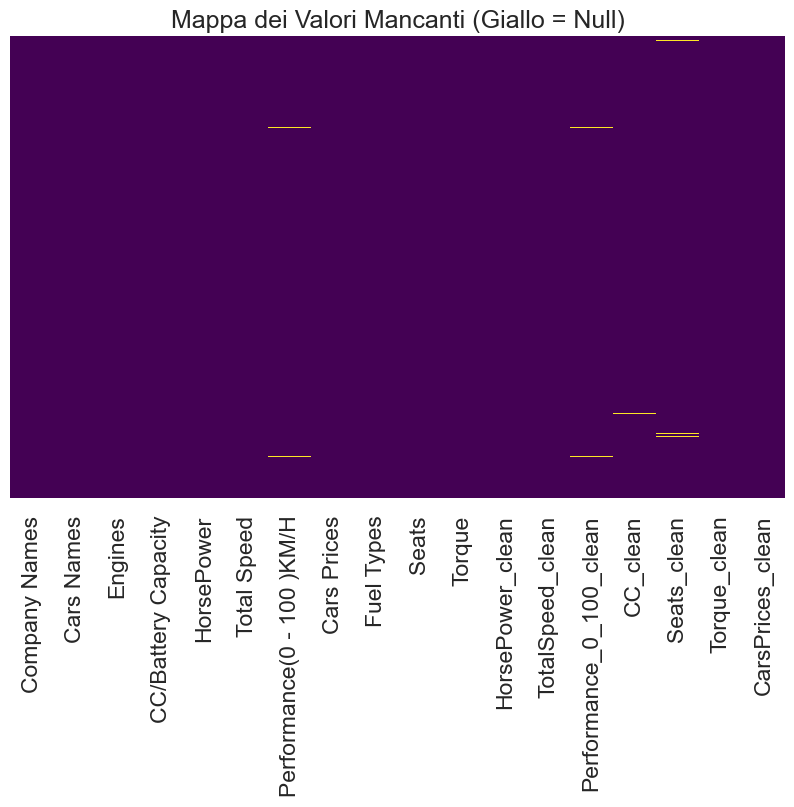

In [118]:
# Contare i nulli per ogni colonna
print("\n--- CONTEGGIO VALORI NULLI PRE-PULIZIA ---")
null_counts = df.isnull().sum()
print(null_counts)

# Visualizzazione grafica dei dati mancanti
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

plt.title('Mappa dei Valori Mancanti (Giallo = Null)')
plt.show()

In [119]:
# Elimino le righe che contengono nulli ovunque
righe_con_null = df[df.isnull().any(axis=1)]
print("Righe eliminate:")
display(righe_con_null)

df = df.dropna()

Righe eliminate:


,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque,HorsePower_clean,TotalSpeed_clean,Performance_0_100_clean,CC_clean,Seats_clean,Torque_clean,CarsPrices_clean
11,FERRARI,PORTOFINO,V8,"3,900 cc",592 hp,320 km/h,3.2 sec,"$210,000",Petrol,2+2,760 Nm,592.0,320.0,3.2,451.5,NaN,760.0,210000.0
12,FERRARI,ROMA,V8,"3,900 cc",612 hp,320 km/h,3.4 sec,"$230,000",Petrol,2+2,760 Nm,612.0,320.0,3.4,451.5,NaN,760.0,230000.0
15,FERRARI,PORTOFINO M,V8,"3,900 cc",612 hp,320 km/h,3.2 sec,"$220,000",Petrol,2+2,760 Nm,612.0,320.0,3.2,451.5,NaN,760.0,220000.0
16,FERRARI,ROMA SPIDER,V8,"3,900 cc",612 hp,320 km/h,3.4 sec,"$240,000",Petrol,2+2,760 Nm,612.0,320.0,3.4,451.5,NaN,760.0,240000.0
18,TOYOTA,TOYOTA 86,BOXER-4,"1,998 cc",205 hp,226 km/h,6.4 sec,"$27,000",Petrol,2+2,205 Nm,205.0,226.0,6.4,499.5,NaN,205.0,27000.0
97,MERCEDES,BENZ EQS 53,ELECTRIC MOTOR,NaN,751 hp,250 km/h,3.4 sec,"$102,000",Electric,5,950 Nm,751.0,250.0,3.4,NaN,5.0,950.0,102000.0
241,TOYOTA,COASTER,"4.0L,DIESEL","4,009 cc",134 hp,120 km/h,NaN,"$70,000",Diesel,20,500 Nm,134.0,120.0,NaN,6.5,20.0,500.0,70000.0
255,Nissan,Urvan,2.5L Turbo Diese,NaN,2488 cc,140 km/h,14.0 sec,"$28,000",Diesel,15,356 Nm,2488.0,140.0,14.0,NaN,15.0,356.0,28000.0
994,Peugeot,Partner Electric,Electric Motor,-,136 hp,130 km/h,9.0 sec,"$40,000",Electric,5,260 Nm,136.0,130.0,9.0,NaN,5.0,260.0,40000.0
995,Peugeot,Expert Electric,Electric Motor,-,136 hp,130 km/h,9.5 sec,"$45,000",Electric,5,260 Nm,136.0,130.0,9.5,NaN,5.0,260.0,45000.0



--- CONTEGGIO VALORI NULLI POST-PULIZIA ---
Company Names                0
Cars Names                   0
Engines                      0
CC/Battery Capacity          0
HorsePower                   0
Total Speed                  0
Performance(0 - 100 )KM/H    0
Cars Prices                  0
Fuel Types                   0
Seats                        0
Torque                       0
HorsePower_clean             0
TotalSpeed_clean             0
Performance_0_100_clean      0
CC_clean                     0
Seats_clean                  0
Torque_clean                 0
CarsPrices_clean             0
dtype: int64


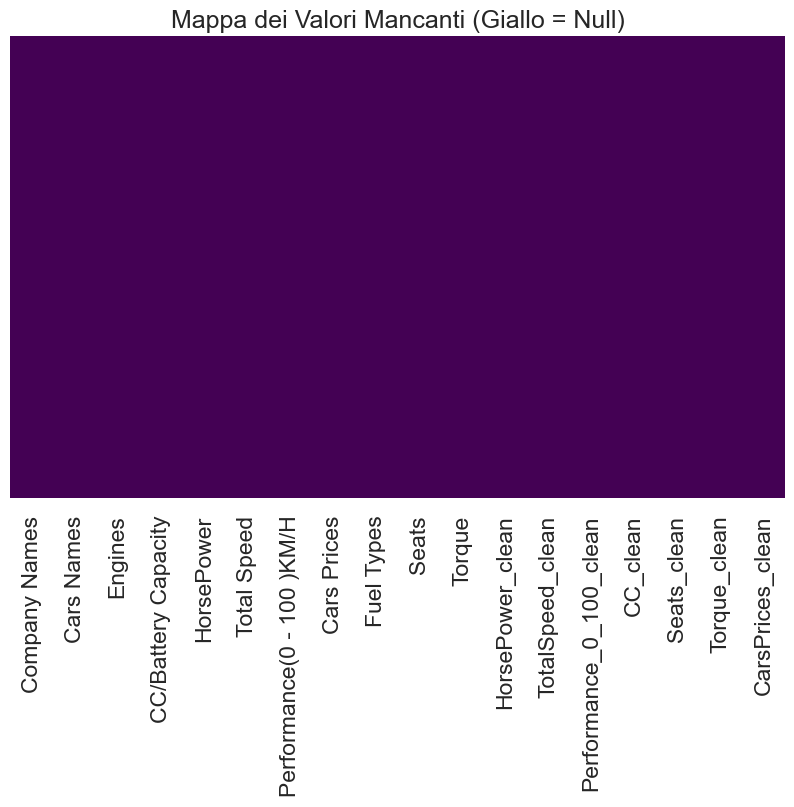

In [120]:
print("\n--- CONTEGGIO VALORI NULLI POST-PULIZIA ---")
null_counts = df.isnull().sum()
print(null_counts)

# Visualizzazione grafica dei dati mancanti
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

plt.title('Mappa dei Valori Mancanti (Giallo = Null)')
plt.show()

INFO E STATISTICHE DESCRITTIVE

In [121]:
# Info dataset
print("\n--- INFO GENERALI ---")
df.info()


--- INFO GENERALI ---
<class 'pandas.core.frame.DataFrame'>
Index: 1196 entries, 0 to 1217
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Company Names              1196 non-null   object 
 1   Cars Names                 1196 non-null   object 
 2   Engines                    1196 non-null   object 
 3   CC/Battery Capacity        1196 non-null   object 
 4   HorsePower                 1196 non-null   object 
 5   Total Speed                1196 non-null   object 
 6   Performance(0 - 100 )KM/H  1196 non-null   object 
 7   Cars Prices                1196 non-null   object 
 8   Fuel Types                 1196 non-null   object 
 9   Seats                      1196 non-null   object 
 10  Torque                     1196 non-null   object 
 11  HorsePower_clean           1196 non-null   float64
 12  TotalSpeed_clean           1196 non-null   float64
 13  Performance_0_100_clean    119

In [122]:
# Statistiche descrittive
print("\n--- DESCRIZIONE STATISTICA ---")
print(df.describe())


--- DESCRIZIONE STATISTICA ---
       HorsePower_clean  TotalSpeed_clean  Performance_0_100_clean  \
count       1196.000000       1196.000000              1196.000000   
mean         300.902592        216.928094                 7.562542   
std          208.791555         52.414104                 3.309369   
min            0.500000         80.000000                 1.900000   
25%          151.750000        180.000000                 5.300000   
50%          250.000000        200.000000                 7.100000   
75%          400.000000        250.000000                 9.500000   
max         1850.000000        500.000000                35.000000   

           CC_clean  Seats_clean  Torque_clean  CarsPrices_clean  
count   1196.000000  1196.000000   1196.000000      1.196000e+03  
mean    1514.182773     4.847826    428.101449      1.389795e+05  
std     1935.148650     1.402420    288.925921      7.171649e+05  
min        0.500000     1.000000      5.000000      4.000000e+03  
25

OUTLIER

In [123]:
numeric_cols = [
    "HorsePower_clean",
    "TotalSpeed_clean",
    "CarsPrices_clean",
    "Torque_clean",
    "CC_clean",
    "Performance_0_100_clean"
]

In [124]:
def find_outliers(df, col): # Funzione per calcolare IQR e individuare outlier
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

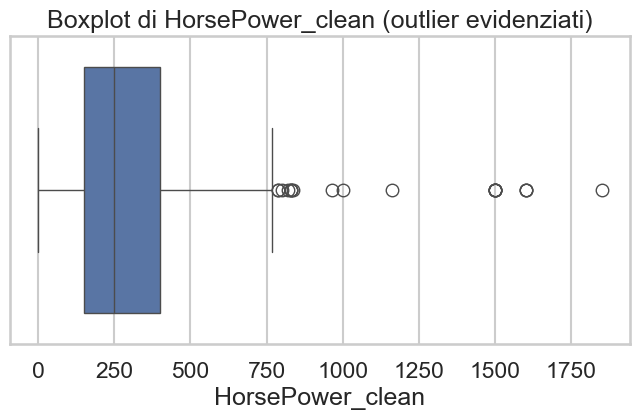


Colonna: HorsePower_clean
Numero di outlier: 21
     HorsePower_clean
0               963.0
10              789.0
13              789.0
32             1160.0
33             1000.0
41              836.0
42              819.0
667             800.0
795             830.0
810             830.0
819             830.0
880            1500.0
881            1500.0
882            1600.0
883            1500.0
884            1500.0
885            1500.0
886            1600.0
887            1500.0
888            1850.0
889            1600.0


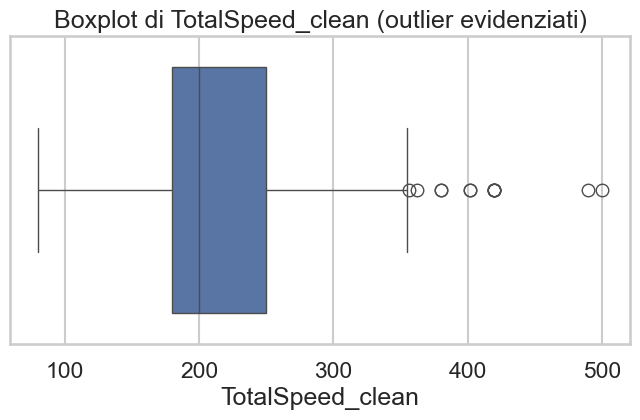


Colonna: TotalSpeed_clean
Numero di outlier: 13
     TotalSpeed_clean
8               356.0
32              402.0
33              362.0
668             402.0
880             420.0
882             490.0
883             420.0
884             420.0
885             380.0
886             380.0
887             420.0
888             500.0
889             420.0


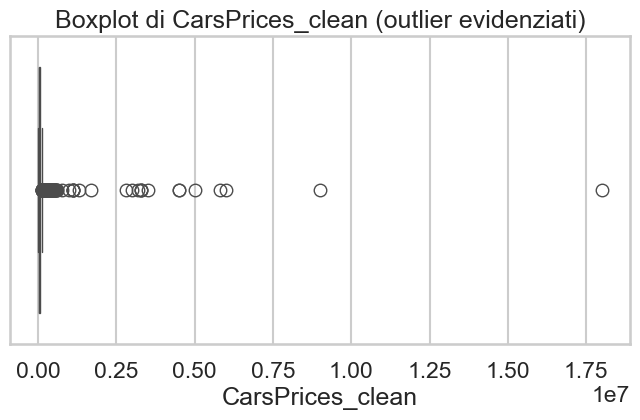


Colonna: CarsPrices_clean
Numero di outlier: 144
      CarsPrices_clean
0            1100000.0
1             460000.0
3             161000.0
4             253290.0
5             499000.0
...                ...
953           150000.0
958           157000.0
961           157000.0
1036          500000.0
1212         6000000.0

[144 rows x 1 columns]


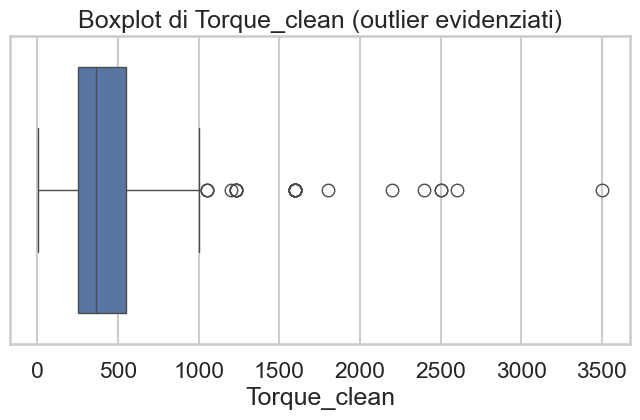


Colonna: Torque_clean
Numero di outlier: 26
      Torque_clean
561         1050.0
607         1050.0
716         1234.0
739         1234.0
749         1234.0
768         1234.0
776         1234.0
880         1600.0
881         1600.0
882         1600.0
883         1600.0
884         1600.0
885         1600.0
886         1600.0
887         1600.0
888         1600.0
889         1600.0
890         2600.0
891         3500.0
892         2200.0
893         2500.0
894         2400.0
895         1800.0
896         2500.0
897         1200.0
1032        1051.0


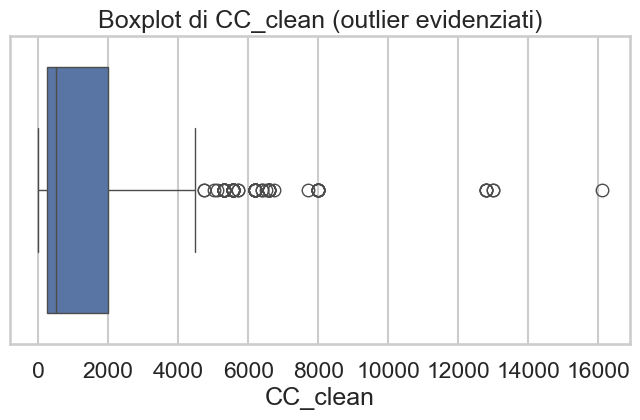


Colonna: CC_clean
Numero di outlier: 86
     CC_clean
1      6749.0
10     6496.0
383    5552.0
387    5552.0
400    5552.0
..        ...
894   12800.0
895   12800.0
896   12800.0
897    7700.0
898    5100.0

[86 rows x 1 columns]


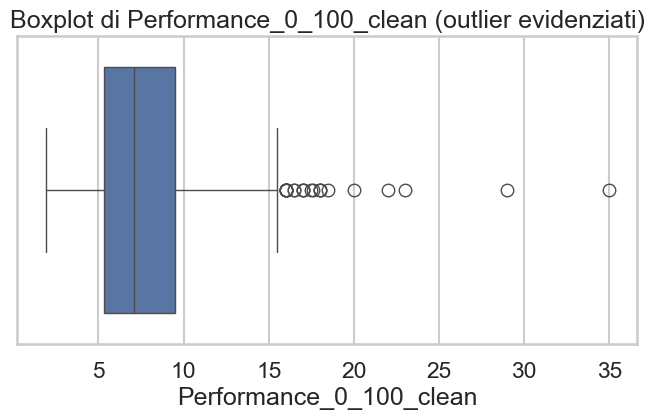


Colonna: Performance_0_100_clean
Numero di outlier: 23
      Performance_0_100_clean
317                      23.0
318                      17.5
477                      18.0
478                      18.5
635                      29.0
636                      16.0
637                      16.0
641                      16.5
643                      17.0
645                      17.0
652                      16.0
655                      17.6
892                      16.0
893                      16.5
895                      17.0
896                      18.0
897                      20.0
898                      22.0
1125                     16.0
1162                     16.0
1174                     18.0
1182                     16.0
1197                     35.0


In [125]:
for col in numeric_cols: # Loop su tutte le colonne
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot di {col} (outlier evidenziati)')
    plt.show()

    outliers = find_outliers(df, col)
    print(f"\nColonna: {col}")
    print(f"Numero di outlier: {len(outliers)}")
    if len(outliers) > 0:
        print(outliers[[col]])

MATRICE CORRELAZIONE

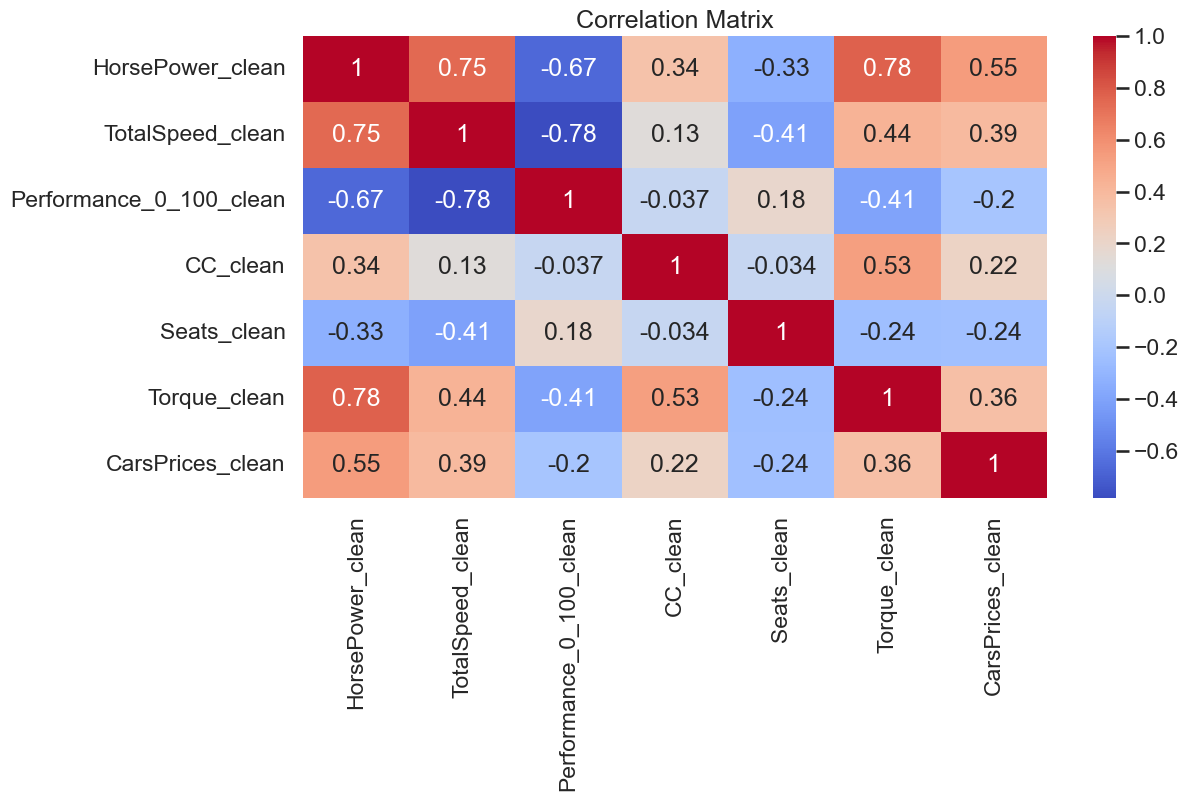

In [126]:
# Matrice di correlazione tra colonne numeriche
corr = df.corr(numeric_only=True)

# Rappresentazione con heatmap
sns.heatmap(
    corr, 
    annot=True, # Mostra i valori numerici
    cmap="coolwarm"
)

plt.title("Correlation Matrix")
plt.show()

RELAZIONE: CAVALLI VS PERFORMANCE

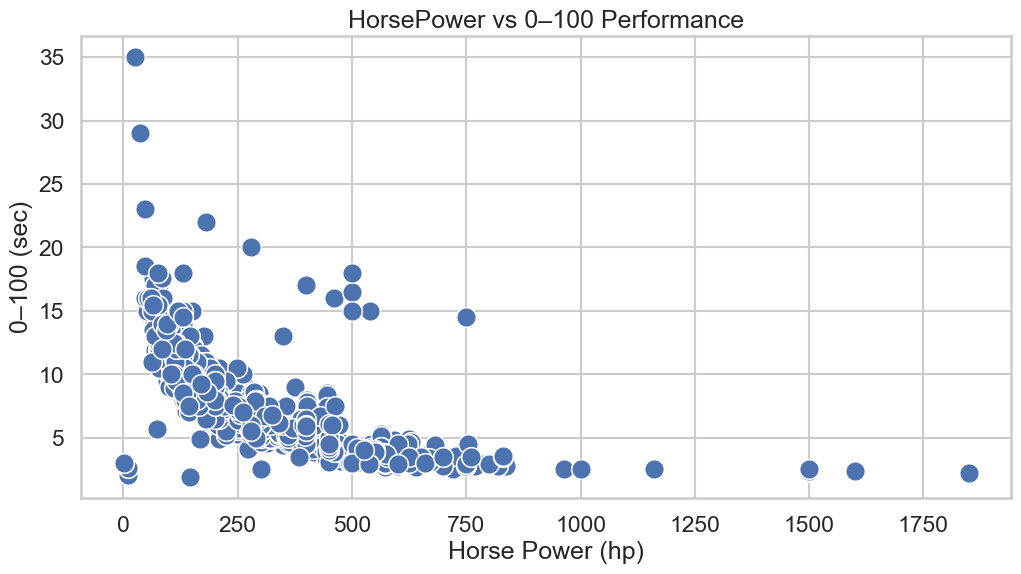

In [127]:
# Grafico a dispersione
sns.scatterplot(
    data=df, 
    x="HorsePower_clean", 
    y="Performance_0_100_clean",
    s=200   # Dimensione punti
)

plt.title("HorsePower vs 0–100 Performance")
plt.xlabel("Horse Power (hp)")
plt.ylabel("0–100 (sec)")
plt.show()

RELAZIONE: CAVALLI VS TOTAL SPEED

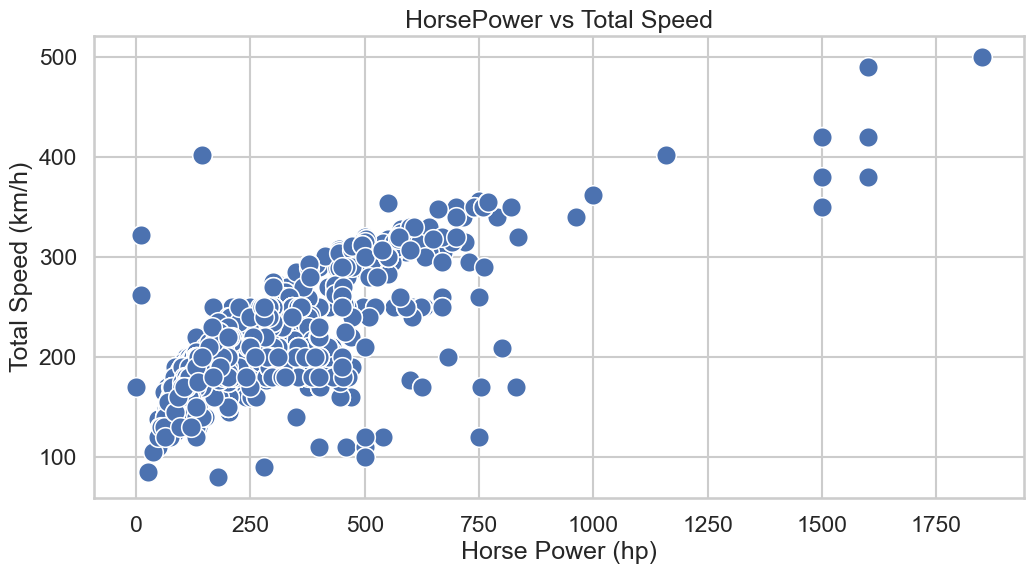

In [128]:
# Grafico a dispersione
sns.scatterplot(
    data=df, 
    x="HorsePower_clean", 
    y="TotalSpeed_clean",
    s=200   # Dimensione punti
)

plt.title("HorsePower vs Total Speed")
plt.xlabel("Horse Power (hp)")
plt.ylabel("Total Speed (km/h)")
plt.show()